In [1]:
code_dir = '../../../reference-matching-evaluation/'
data_dir = 'data/'
img_dir = 'images/'

In [2]:
import sys
sys.path.append(code_dir)

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from dataset.dataset_utils import get_target_gt_doi, get_target_test_doi
from evaluation.evaluation_utils import doi_test_same, doi_equals
from evaluation.link_metrics import LinkMetricsResults
from scipy.stats import chi2_contingency
from utils.utils import read_json

In [3]:
def print_summary(dataset, name):
    link_results = LinkMetricsResults(dataset)
    print('{} precision: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_PREC),
                  link_results.get(dfk.EVAL_CI_PREC)[0], link_results.get(dfk.EVAL_CI_PREC)[1]))
    print('{} recall: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_REC),
                  link_results.get(dfk.EVAL_CI_REC)[0], link_results.get(dfk.EVAL_CI_REC)[1]))
    print('{} F1: {:.4f}'.format(name, link_results.get(dfk.EVAL_F1)))

In [4]:
dataset_stq = read_json(data_dir + 'sample_stq.json')[dfk.DATASET_DATASET]
print_summary(dataset_stq, 'STQ')

STQ precision: 0.9895 (CI at 95% 0.9833-0.9957)
STQ recall: 0.8685 (CI at 95% 0.8493-0.8877)
STQ F1: 0.9251


In [5]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_valid_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

In [6]:
dataset_sbm_simple = read_json(data_dir + 'sample_sbm.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbm_simple, 64)
print_summary(dataset_sbm_simple, 'SBM')

SBM precision: 0.8686 (CI at 95% 0.8488-0.8883)
SBM recall: 0.8191 (CI at 95% 0.7973-0.8409)
SBM F1: 0.8431


In [7]:
dataset_sbm_norm = read_json(data_dir + 'sample_sbm.json')[dfk.DATASET_DATASET]
modify_norm_threshold(dataset_sbm_norm, 0.4)
print_summary(dataset_sbm_norm, 'SBM')

SBM precision: 0.7712 (CI at 95% 0.7493-0.7932)
SBM recall: 0.9121 (CI at 95% 0.8960-0.9281)
SBM F1: 0.8358


In [8]:
dataset_sbmv = read_json(data_dir + 'sample_sbmv.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbmv, 0.34) 
print_summary(dataset_sbmv, 'SBMV')

SBMV precision: 0.9809 (CI at 95% 0.9730-0.9888)
SBMV recall: 0.9456 (CI at 95% 0.9327-0.9584)
SBMV F1: 0.9629


In [9]:
def get_means(dataset):
    results = LinkMetricsResults(dataset)
    return [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC, dfk.EVAL_F1]]

def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 15})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

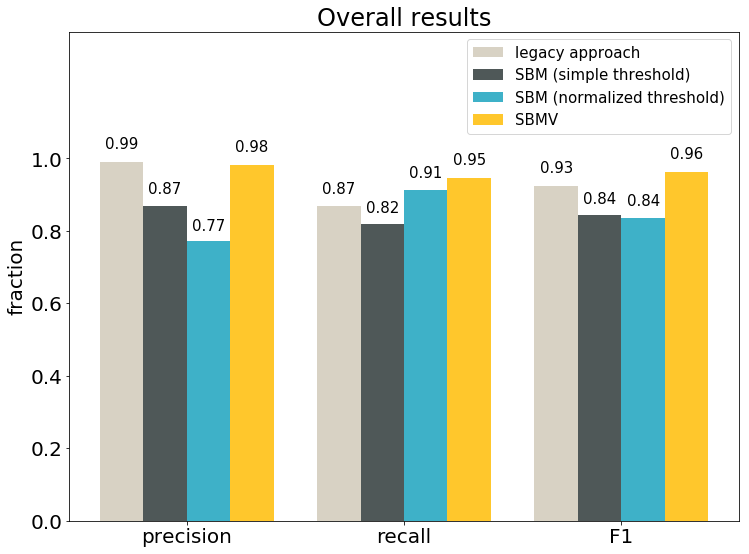

In [10]:
ind = np.arange(3)
width = 0.2
plt.rcParams.update({'font.size': 20, 'legend.fontsize': 15}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - width, get_means(dataset_stq), width=width, color='#d8d2c4')
rects2 = ax.bar(ind, get_means(dataset_sbm_simple), width=width, color='#4f5858')
rects3 = ax.bar(ind + width, get_means(dataset_sbm_norm), width=width, color='#3eb1c8')
rects4 = ax.bar(ind + 2 * width, get_means(dataset_sbmv), width=width, color='#ffc72c')

ax.set_ylabel('fraction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.title("Overall results")
plt.ylim(0, 1.35)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
          ('legacy approach', 'SBM (simple threshold)', 'SBM (normalized threshold)', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)

plt.savefig(img_dir + 'overall.png', dpi=300, bbox_inches='tight')

In [11]:
for metric in [dfk.EVAL_PREC, dfk.EVAL_REC]:
    fun = get_target_test_doi if metric == dfk.EVAL_PREC else get_target_gt_doi
    stq_results = LinkMetricsResults(dataset_stq)
    stq_precision = stq_results.get(metric)
    stq_test_count = len([d for d in dataset_stq if fun(d) is not None])
    stq_precision_success = int(stq_precision * stq_test_count)

    sbmv_results = LinkMetricsResults(dataset_sbmv)
    sbmv_precision = sbmv_results.get(metric)
    sbmv_test_count = len([d for d in dataset_sbmv if fun(d) is not None])
    sbmv_precision_success = int(sbmv_precision * sbmv_test_count)

    _, p, _, _ = chi2_contingency(np.array([[stq_precision_success,
                                             stq_test_count-stq_precision_success],
                                           [sbmv_precision_success,
                                            sbmv_test_count-sbmv_precision_success]]),
                                  correction=True)
    c = 'this is statistically significant' if p < 0.05 \
        else 'this is not statistically significant'
    print('{} p-value: {:.4f} ({})'.format(metric, p, c))

precision p-value: 0.1377 (this is not statistically significant)
recall p-value: 0.0000 (this is statistically significant)


In [12]:
dataset_sbmv = read_json(data_dir + 'sample_sbmv.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbmv, 0.34) 

orig_links = len([d for d in dataset_stq if get_target_test_doi(d) is not None])
sbmv_new_links = len([d_sbmv for d_orig, d_sbmv in zip(dataset_stq, dataset_sbmv)
                      if get_target_test_doi(d_sbmv) is not None
                      and get_target_test_doi(d_orig) is None])
sbmv_new_correct_links = len([d_sbmv for d_orig, d_sbmv in zip(dataset_stq, dataset_sbmv)
                              if get_target_test_doi(d_sbmv) is not None
                              and get_target_test_doi(d_orig) is None
                              and doi_equals(d_sbmv)])

print('Applying SBMV to currently not resolved links will result in {:.2f}% more links'
      .format(100*sbmv_new_links/orig_links))
print('{:.2f}% of the new links will be correct'.format(100*sbmv_new_correct_links/sbmv_new_links))

Applying SBMV to currently not resolved links will result in 12.02% more links
88.89% of the new links will be correct


In [13]:
data = read_json(data_dir + 'comparison-reasons.json')
sbm_link = 'search_API_link'
sbm_score = 'search_API_score'
gt_link = 'gt'
res = [d.update({sbm_link: None}) for d in data if d[sbm_score] is not None and d[sbm_score] < 0.34]
print('Dataset size: {}'.format(len(data)))

Dataset size: 2000


In [14]:
data_correct_res = [d for d in data if d[sbm_link] == d[gt_link] and d[sbm_link] is not None]
print('Correctly resolved references: {} ({:.2f}%)'.format(len(data_correct_res),
                                                           100*len(data_correct_res)/len(data)))

Correctly resolved references: 1129 (56.45%)


In [15]:
data_correct_not_res = [d for d in data if d[sbm_link] == d[gt_link] and d[sbm_link] is None]
print('Correctly not resolved references: {} ({:.2f}%)'
      .format(len(data_correct_not_res), 100*len(data_correct_not_res)/len(data)))

Correctly not resolved references: 791 (39.55%)


In [16]:
data_incorrect_res = [d for d in data if d[sbm_link] != d[gt_link] and d[sbm_link] is not None
                      and d[gt_link] is not None]
print('References resolved to the wrong document: {} ({:.2f}%)'
      .format(len(data_incorrect_res), 100*len(data_incorrect_res)/len(data)))

References resolved to the wrong document: 7 (0.35%)


In [17]:
def summarize_causes(data):
    causes = [d['reason'] for d in data]
    causes = list(set([(r, causes.count(r)) for r in causes]))
    causes.sort(key=lambda x: x[1], reverse=True) 
    return causes

summarize_causes(data_incorrect_res)

[('no title in the ref string', 2),
 ('similar metadata', 2),
 ('search score too low to be considered as a candidate', 1),
 ('chapter matched instead of the book', 1),
 ('two similar papers differ by journal name only', 1)]

In [18]:
data_incorrect_not_res = [d for d in data if d[sbm_link] is None and d[gt_link] is not None]
print('Missing links: {} ({:.2f}%)'
      .format(len(data_incorrect_not_res), 100*len(data_incorrect_not_res)/len(data)))

Missing links: 58 (2.90%)


In [19]:
summarize_causes(data_incorrect_not_res)

[('missing author in the metadata', 8),
 ('missing year in the metadata', 7),
 ('search score too low to be considered as a candidate', 7),
 ('year mismatch', 5),
 ('missing author in the ref string', 4),
 ('DOI resolvable but not visible in API', 4),
 ('no numbers in the ref string except for arXiv id', 4),
 ('missing year and pages in the metadata', 4),
 ('search score too low to be considered as a candidate; no title in the ref string',
  3),
 ('missing title in the ref string', 2),
 ('missing title in the metadata', 2),
 ('ref string contains a large HTML fragment', 2),
 ('matcher error', 1),
 ('title given in different language in the ref string', 1),
 ('no title or numbers in the ref string', 1),
 ("author's entire name as family name in the metadata, ref string contains abbreviated first name",
  1),
 ('missing author in the ref string, missing year in the metadata', 1),
 ('missing year in the ref string', 1)]

In [20]:
data_incorrect_extra_res = [d for d in data if d[sbm_link] is not None and d[gt_link] is None]
print('Incorrect extra links: {} ({:.2f}%)'
      .format(len(data_incorrect_extra_res), 100*len(data_incorrect_extra_res)/len(data)))

Incorrect extra links: 15 (0.75%)


In [21]:
summarize_causes(data_incorrect_extra_res)

[('multiple references in the string', 6),
 ('similar metadata', 4),
 ('journal article matched; chapter/book referenced', 2),
 ('journal article matched; working paper referenced', 1),
 ('different versions of the paper', 1),
 ('conference paper matched; phd thesis referenced', 1)]

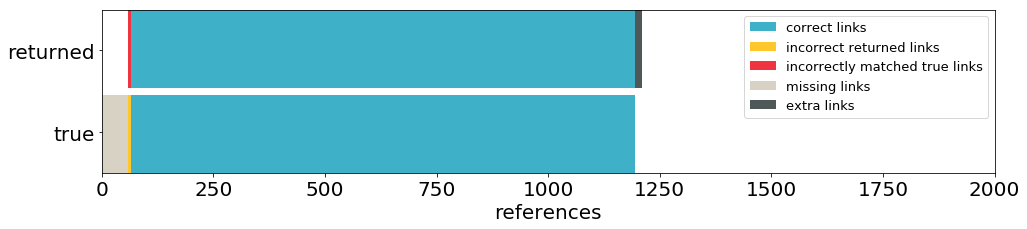

In [22]:
ind = np.arange(3)
plt.rcParams.update({'font.size': 20, 'legend.fontsize': 13}) 
fig, ax = plt.subplots(figsize=(16, 3))

rects1 = ax.bar(29, 0.48, 58, color='#d8d2c4')
rects2 = ax.bar(61.5, 0.48, 7, color='#ffc72c')
rects3 = ax.bar(65+1129/2, 0.48, 1129, color='#3eb1c8')
rects4 = ax.bar(61.5, 0.5, 7, bottom=0.52, color='#ef3340')
rects5 = ax.bar(65+1129/2, 0.5, 1129, bottom=0.52, color='#3eb1c8')
rects6 = ax.bar(1194+15/2, 0.5, 15, bottom=0.52, color='#4f5858')

plt.xlim(0, 2000)
plt.xlabel('references')
plt.ylim(0, 1)
plt.yticks([0.25, 0.75])
ax.set_yticklabels(('true', 'returned'))
ax.legend((rects3[0], rects2[0], rects4[0], rects1[0], rects6[0]),
          ('correct links', 'incorrect returned links', 'incorrectly matched true links', 'missing links',
           'extra links'))

plt.savefig(img_dir + 'references.png', dpi=300, bbox_inches='tight')

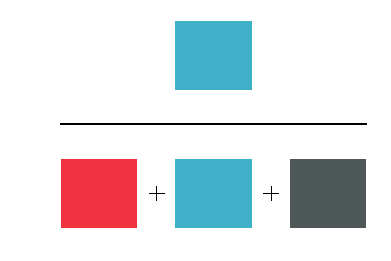

In [23]:
fig, ax = plt.subplots()

ax.bar(0.5, 0.2, 0.2, bottom=0.6, color='#3eb1c8')
ax.bar(0.2, 0.2, 0.2, bottom=0.2, color='#ef3340')
ax.bar(0.5, 0.2, 0.2, bottom=0.2, color='#3eb1c8')
ax.bar(0.8, 0.2, 0.2, bottom=0.2, color='#4f5858')

plt.plot([0.1, 0.9], [0.5, 0.5], 'k-', lw=2)
plt.plot([0.33, 0.37], [0.3, 0.3], 'k-', lw=1)
plt.plot([0.63, 0.67], [0.3, 0.3], 'k-', lw=1)
plt.plot([0.35, 0.35], [0.28, 0.32], 'k-', lw=1)
plt.plot([0.65, 0.65], [0.28, 0.32], 'k-', lw=1)

plt.axis('off')

plt.savefig(img_dir + 'precision.png', dpi=300, bbox_inches='tight')

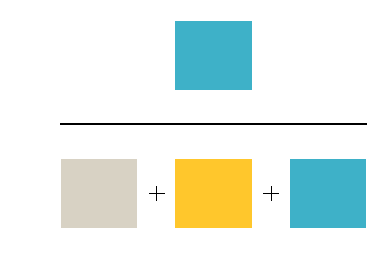

In [24]:
fig, ax = plt.subplots()

ax.bar(0.5, 0.2, 0.2, bottom=0.6, color='#3eb1c8')
ax.bar(0.2, 0.2, 0.2, bottom=0.2, color='#d8d2c4')
ax.bar(0.5, 0.2, 0.2, bottom=0.2, color='#ffc72c')
ax.bar(0.8, 0.2, 0.2, bottom=0.2, color='#3eb1c8')

plt.plot([0.1, 0.9], [0.5, 0.5], 'k-', lw=2)
plt.plot([0.33, 0.37], [0.3, 0.3], 'k-', lw=1)
plt.plot([0.63, 0.67], [0.3, 0.3], 'k-', lw=1)
plt.plot([0.35, 0.35], [0.28, 0.32], 'k-', lw=1)
plt.plot([0.65, 0.65], [0.28, 0.32], 'k-', lw=1)

plt.axis('off')

plt.savefig(img_dir + 'recall.png', dpi=300, bbox_inches='tight')